# Team members: 
Anqi Chen, Wenyun Wang, Hanyue Wang

# References:
- "Time Series Analysis with Applications in R" by Jonathan D. Cryer and Kung-Sik Chan

- https://docs.pymc.io/en/v3/pymc-examples/examples/time_series/AR.html

- https://en.wikipedia.org/wiki/Autoregressive_model


In [22]:
import condensate_speckle
from condensate_speckle.data_io import get_example_data_file_path, load_data
from condensate_speckle.inference.model import set_model

# General model & simulating data

We are using first order autoregression model as our general model. The overal general form of autoregression model is $Y_t=\sum_{i=1}^{p}\phi_i\times Y_{t-i}+e_t$, where $Y$ is the intensity at each time point, $\phi_i$ is the decay parameter that depends on $\tau$, and $e_t$ is the innovation term. For this project, we are using first-order approximation only, known as AR(1) model. That is $$Y_t=\phi\times Y_{t-1}+e_t$$
, where $\phi=\exp(-1/\tau)$. So the equation becomes $Y_t=\exp(-1/\tau)\times Y_{t-1}+e_t$. 

We need to specify three variables in order to build the generative model: the mean $c$ and standard deviation $\sigma_e$ of the innovation term $e_t$, and decay time $\tau$. Here, $e_t$ is considered as Gaussian distribution and $\tau$ is the value that we are most interested in. We also need the distribution noise level of microscope, which is assumed to be a Normal distribution as well.

From the model, the overall data intensity mean can be calculated by $\frac{c}{1-\phi}$ and the intensity variance is $\frac{\sigma_e^2}{1-\phi^2}$. 

In [23]:
import numpy as np
from matplotlib import pyplot as plt
import pymc3 as pm
import arviz as az
import statsmodels.api as sm
import csv

In [24]:
X = load_data('[120, 145]_intensity.csv',data_dir='condensate_speckle/example_data').to_numpy()

/Users/Hanyue/Documents/GitHub/Condensate_speckles/condensate_speckle/example_data/[120, 145]_intensity.csv


In [25]:
data_pds={'t':X[0],'Intensity':X[1]}

In [26]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 10787
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# Fitting simulated data with pymc3 AR(1) model

To fit our model AR1 model, we want to extract the following parameters: decay time, which is the $\tau$ above; stationary is the $\phi$, precision is defined as $\frac{1}{\sigma_e^2}$; center is the innovation mean. Our prior for $\tau$ is uniform from 0 to 50, based on the experimental data time scale; for precision, we also use a uniform prior from 0 to 10 times the calculated precision from simulation parameters; for center, it is uniform from the lowest possible intensity to the highest possible intensity.

Thus, the statistical model we use is:
$$ \tau \sim \text{Uniform} (0,50) $$
$$ \text{precision} \sim \text{Uniform} (0, 1) $$
$$ \mu \sim \text{Uniform} (I_{min}, I_{max}) $$
$$ p(X) \sim \text{AR1} (\text{k} = e^{-1/\tau}, \text{tau_e} = \text{precision}, \text{observed} = X-\mu )$$

In [27]:
quantization = 255
ar1_model=set_model(data_pds['Intensity'],quantization)

In [28]:
estimate = pm.find_MAP(model = ar1_model)

In [29]:
estimate

{'decay_time_interval__': array(47.63817244),
 'precision_interval__': array(153.05822383),
 'noise_std_interval__': array(-3.15807851),
 'y': array([ 6.98894867e-01,  6.24325730e-01,  4.30024037e-01,  4.12288609e-01,
         4.36222870e-01,  4.50245195e-01,  5.32212319e-01,  5.73405961e-01,
         6.46317569e-01,  6.71494450e-01,  7.45881440e-01,  7.34267712e-01,
         7.18618421e-01,  7.17500855e-01,  7.49060384e-01,  8.13240485e-01,
         8.49386409e-01,  8.74504686e-01,  5.81938964e-01,  2.27079981e-01,
        -1.13369917e-02, -1.79400683e-01, -5.13793828e-01, -7.71541519e-01,
        -8.75911136e-01, -1.00591892e+00, -1.23912813e+00, -1.51515696e+00,
        -2.02185131e+00, -2.39063143e+00, -2.66352568e+00, -2.88274933e+00,
        -2.90678969e+00, -2.90113631e+00, -2.81101281e+00, -2.75891665e+00,
        -2.76608361e+00, -2.67195169e+00, -2.48073050e+00, -2.17377895e+00,
        -1.82410340e+00, -1.38977093e+00, -9.35531199e-01, -5.98911208e-01,
        -3.00871492e-0

In [30]:
with ar1_model:
    trace = pm.sample(1000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
    idata = az.from_pymc3(trace)

/var/folders/7g/r91p7_3s5ms7npzg4qybv9680000gn/T/ipykernel_7234/137214802.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 3,666.5
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y, noise_std, precision, decay_time]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 26 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/Hanyue/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


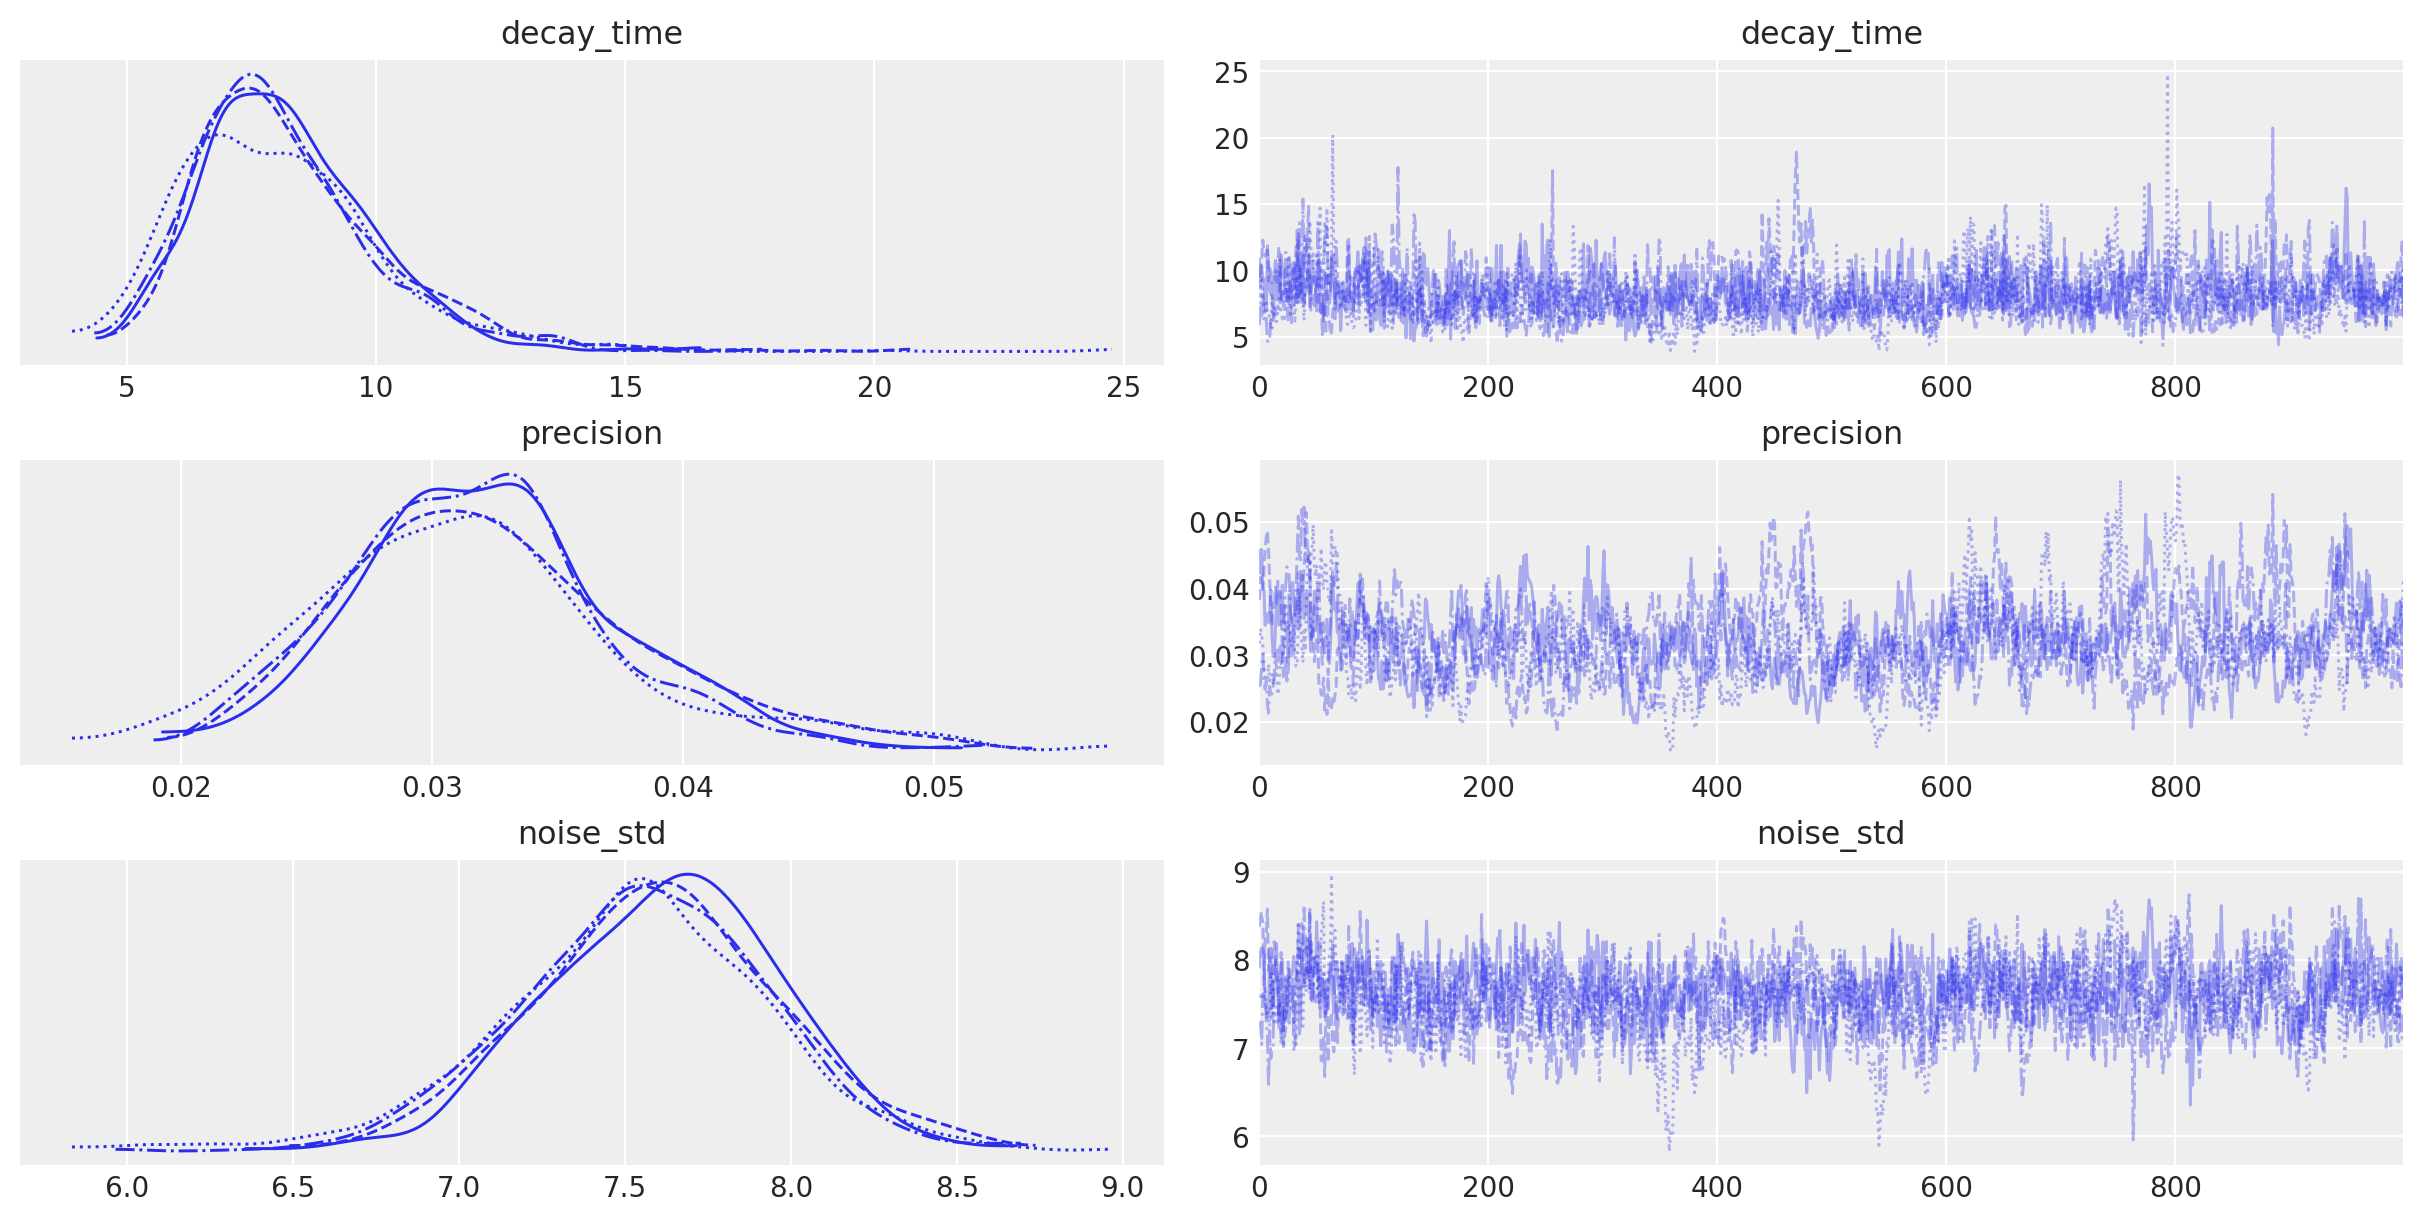

In [32]:
az.plot_trace(
    trace,
    var_names = ['decay_time','precision','noise_std'],
);